In [1]:
"""
Script to Explore Training Dataset
"""
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib
from matplotlib import patches
from utils import utils
import dataframe_image as dfi
from PIL import Image
from collections import defaultdict
# np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
import json
from datetime import datetime
import joblib
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
 
pd.set_option('display.max_rows', 2000)
tagId = "0x683f"
regions_fp = Path().joinpath("outputs", "REGIONS", "2023-03-14 12:15:31.794149.json")
data_fp = Path().joinpath("outputs", "TRAINING", "2023-07-20 09:34:49.929809_W4_S1_training.csv")
# wild_fp = Path().joinpath("outputs", "TRAINING", "2023-04-03 11:53:01.922254_W2_S1_wild_training.csv")
data = pd.read_csv(data_fp)
# wild_data = pd.read_csv(wild_fp)

# Feature Selection
feature_list = ['ACTIVITY','LOCATION', 'Peaks_Acc_X', 'Peaks_Acc_Y', 'Peaks_Acc_Z',  ]
feature_list += data.columns[data.columns.str.contains('POS')].tolist()
feature_list += data.columns[data.columns.str.contains('_ACC')].tolist()
data = data.loc[:, feature_list ]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm, tree
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import datasets, neighbors
from sklearn.neural_network import MLPClassifier

# MARK: - Preprocessing

output_dir = Path().joinpath('outputs', 'MODELS', f'{datetime.now()}')
output_dir.mkdir(parents=True, exist_ok=True)


# Make the encoders
locations = np.reshape(data['LOCATION'].values, (-1, 1))
loc_enc = OneHotEncoder(handle_unknown='ignore')
loc_enc.fit(locations)
joblib.dump(loc_enc, output_dir.joinpath('location_encoder.joblib'))

cleaned_data = (data
                .loc[data.loc[:, 'ACTIVITY'] != "ASSEMBLESANDWICH", :] # Removes assemblesandiwch activity
                .loc[data.loc[:, 'ACTIVITY'] != "UNDEFINED", :] # Removes undefined activity
                # .loc[data.loc[:, 'ACTIVITY'] != "MOP", :] # Removes Mop Activity
                .dropna()
                .reset_index(drop=True)
                .pipe(utils.one_hot_encode_col, 'LOCATION', loc_enc)
                .pipe(utils.drop_columns_that_contain, 'Pressure')
            )

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(cleaned_data['ACTIVITY'].values)
cleaned_data['ACTIVITY'] = encoded_y
joblib.dump(label_encoder, output_dir.joinpath('label_encoder.joblib'))
n_neighbors = 2
weights = 'distance' # or 'distance' which puts more emphasis on certain data
##################################################
#               MODEL SELECTION

#clf = svm.SVC(kernel='linear', C=10) # SVM
#clf = svm.SVC(kernel='poly', degree=3, gamma='scale', C=1000) # SVM (Worked really well except it classified multiple activities as only mop)
# clf = svm.SVC(kernel='rbf', gamma=1000, C=100) # SVM (Horrible performance lol)
#clf = tree.DecisionTreeClassifier(random_state=0) # Decision Tree
#clf = IsolationForest(max_samples=1000, n_estimators = 1000, random_state=0) # Sucks
#clf = RandomForestClassifier( random_state=0)
#clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
#clf = MLPClassifier(solver = 'adam', max_iter = 400) 

##################################################

X = cleaned_data.drop('ACTIVITY', axis=1).values
y = cleaned_data.loc[:, 'ACTIVITY'].values

print("Data Shape: ", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0
)

clf.fit(X_train, y_train)
joblib.dump(clf, output_dir.joinpath('output_model.joblib'))


Data Shape:  (4155, 47) (4155,)


['outputs/MODELS/2023-07-20 14:54:36.154804/output_model.joblib']

['BRUSHTEETH' 'DESKWORK' 'EATING' 'GETPLATE' 'MINCE' 'MOP'
 'OPENDISHWASHER' 'OPENFREEZER' 'OPENFRIDGE' 'SHOWERING' 'SLEEP'
 'SLICETOMATO' 'STATIONARY' 'TIESHOES' 'TOILETING' 'TRANSFER' 'WALK'
 'WASHHANDS' 'WIPE']


/Users/hayden/Github Projects/pozyx-thesis/analysis/utils/utils.py:330: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP/(TP+FN)
/Users/hayden/Github Projects/pozyx-thesis/analysis/utils/utils.py:329: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/(TP+FP)
/Users/hayden/Github Projects/pozyx-thesis/analysis/utils/utils.py:330: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = TP/(TP+FN)
/Users/hayden/Github Projects/pozyx-thesis/analysis/utils/utils.py:329: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/(TP+FP)


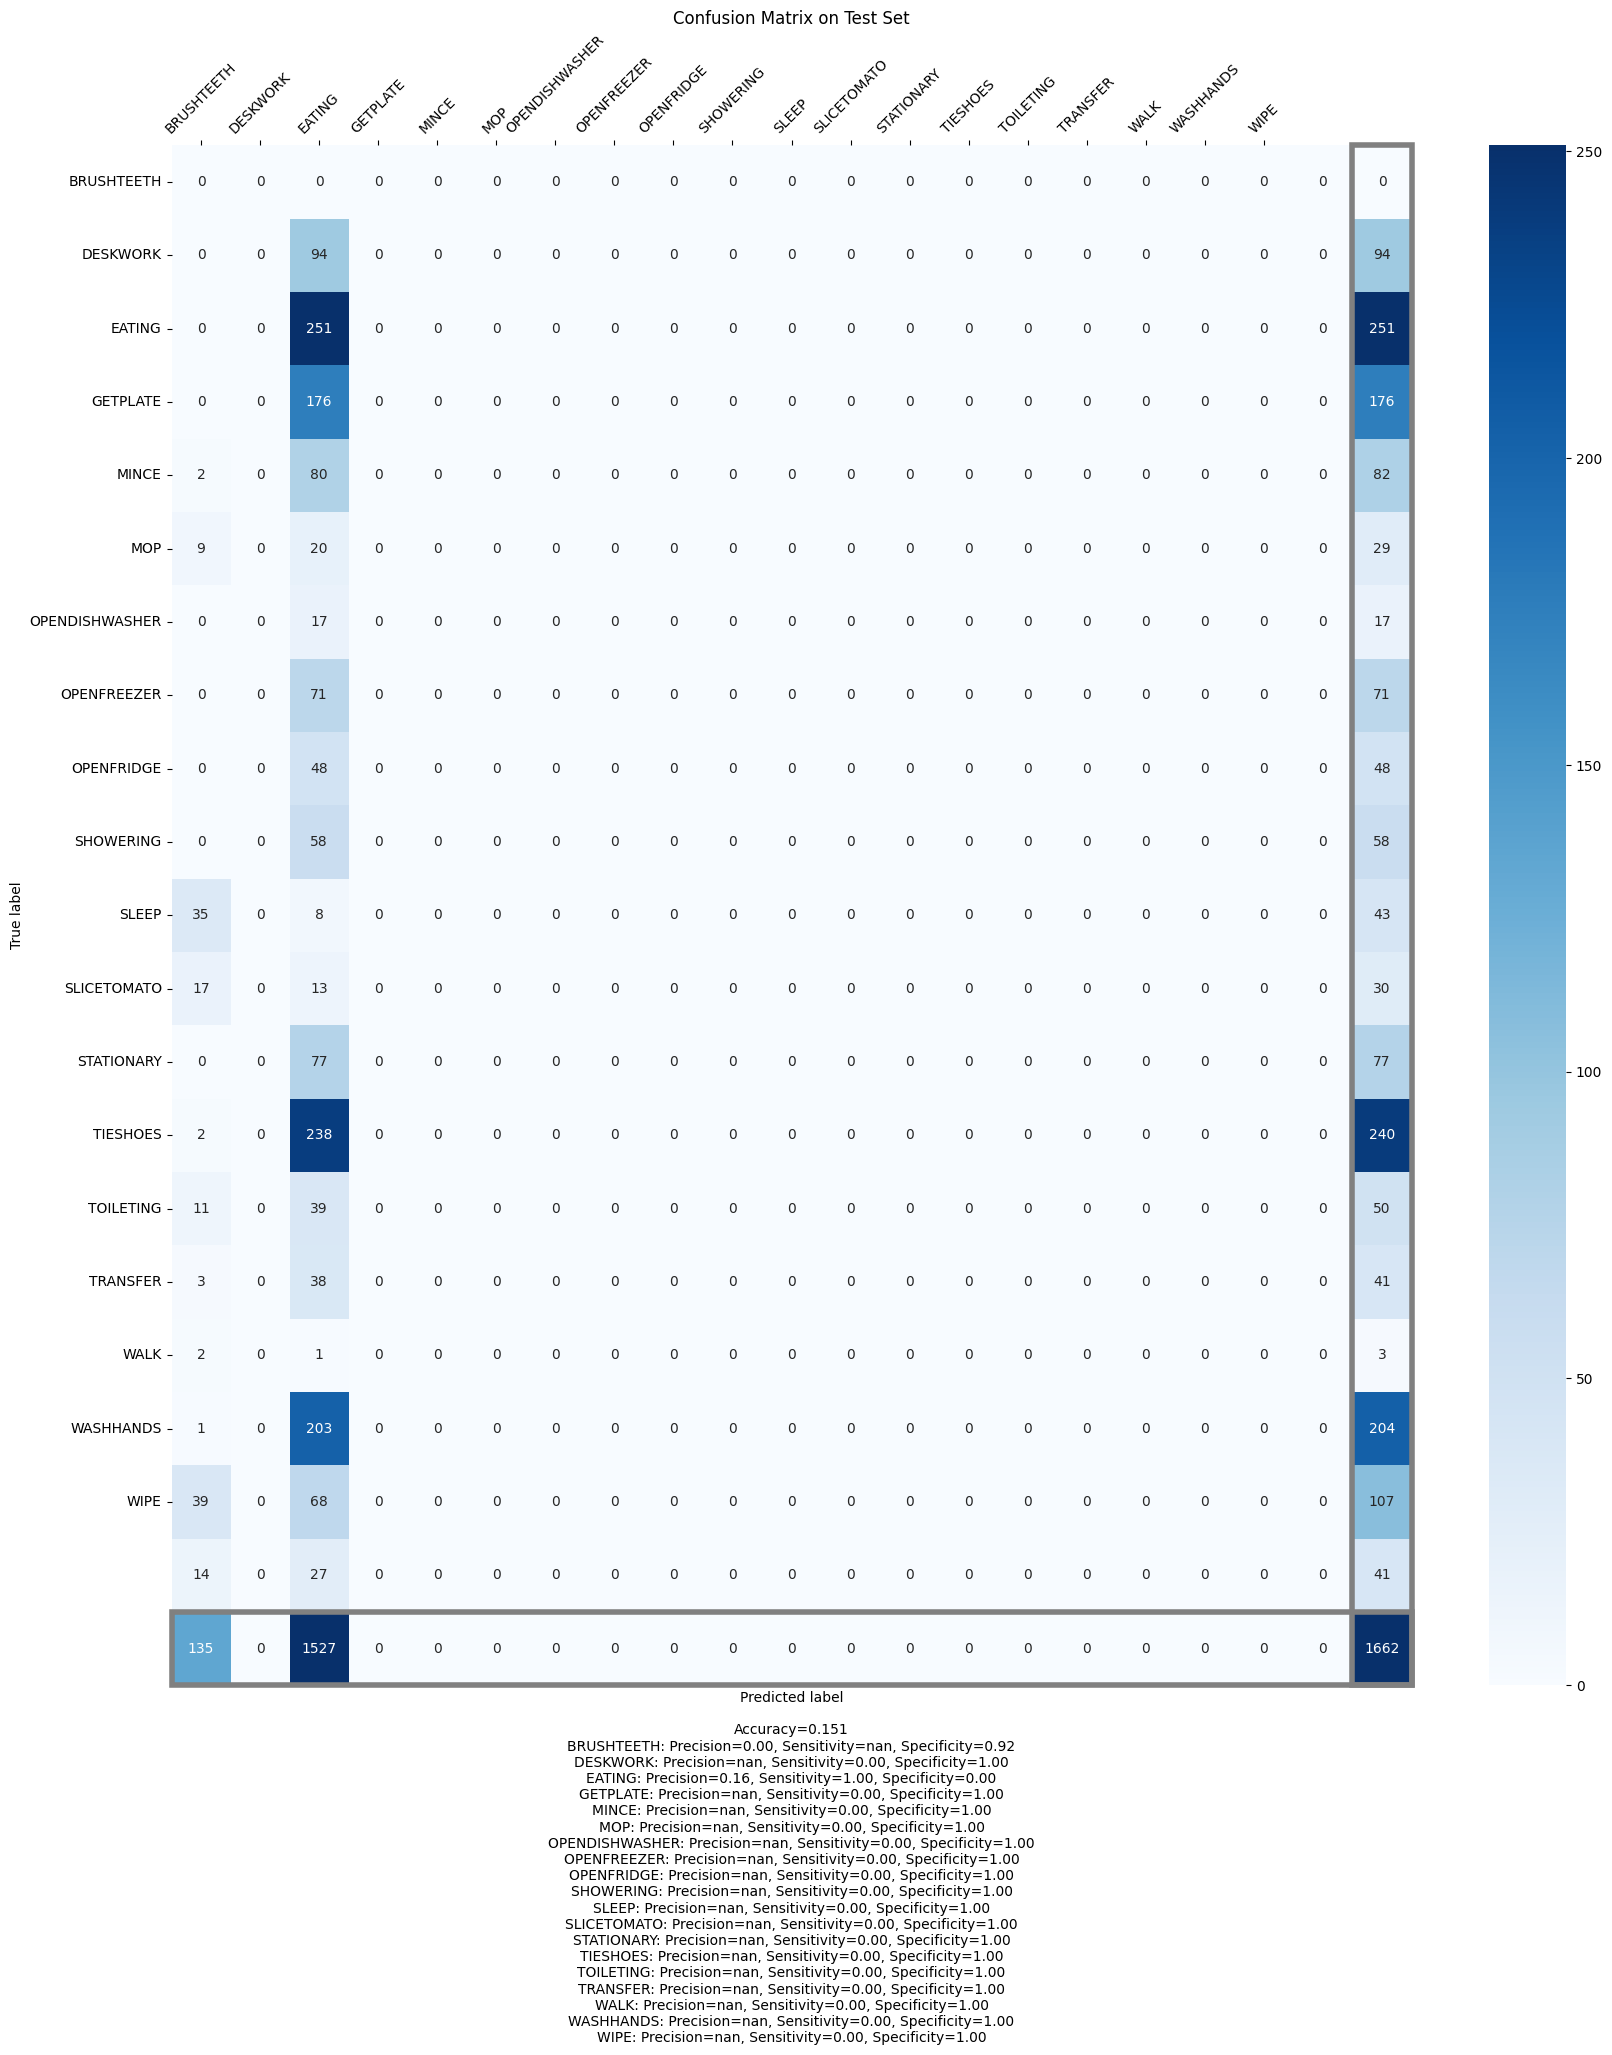

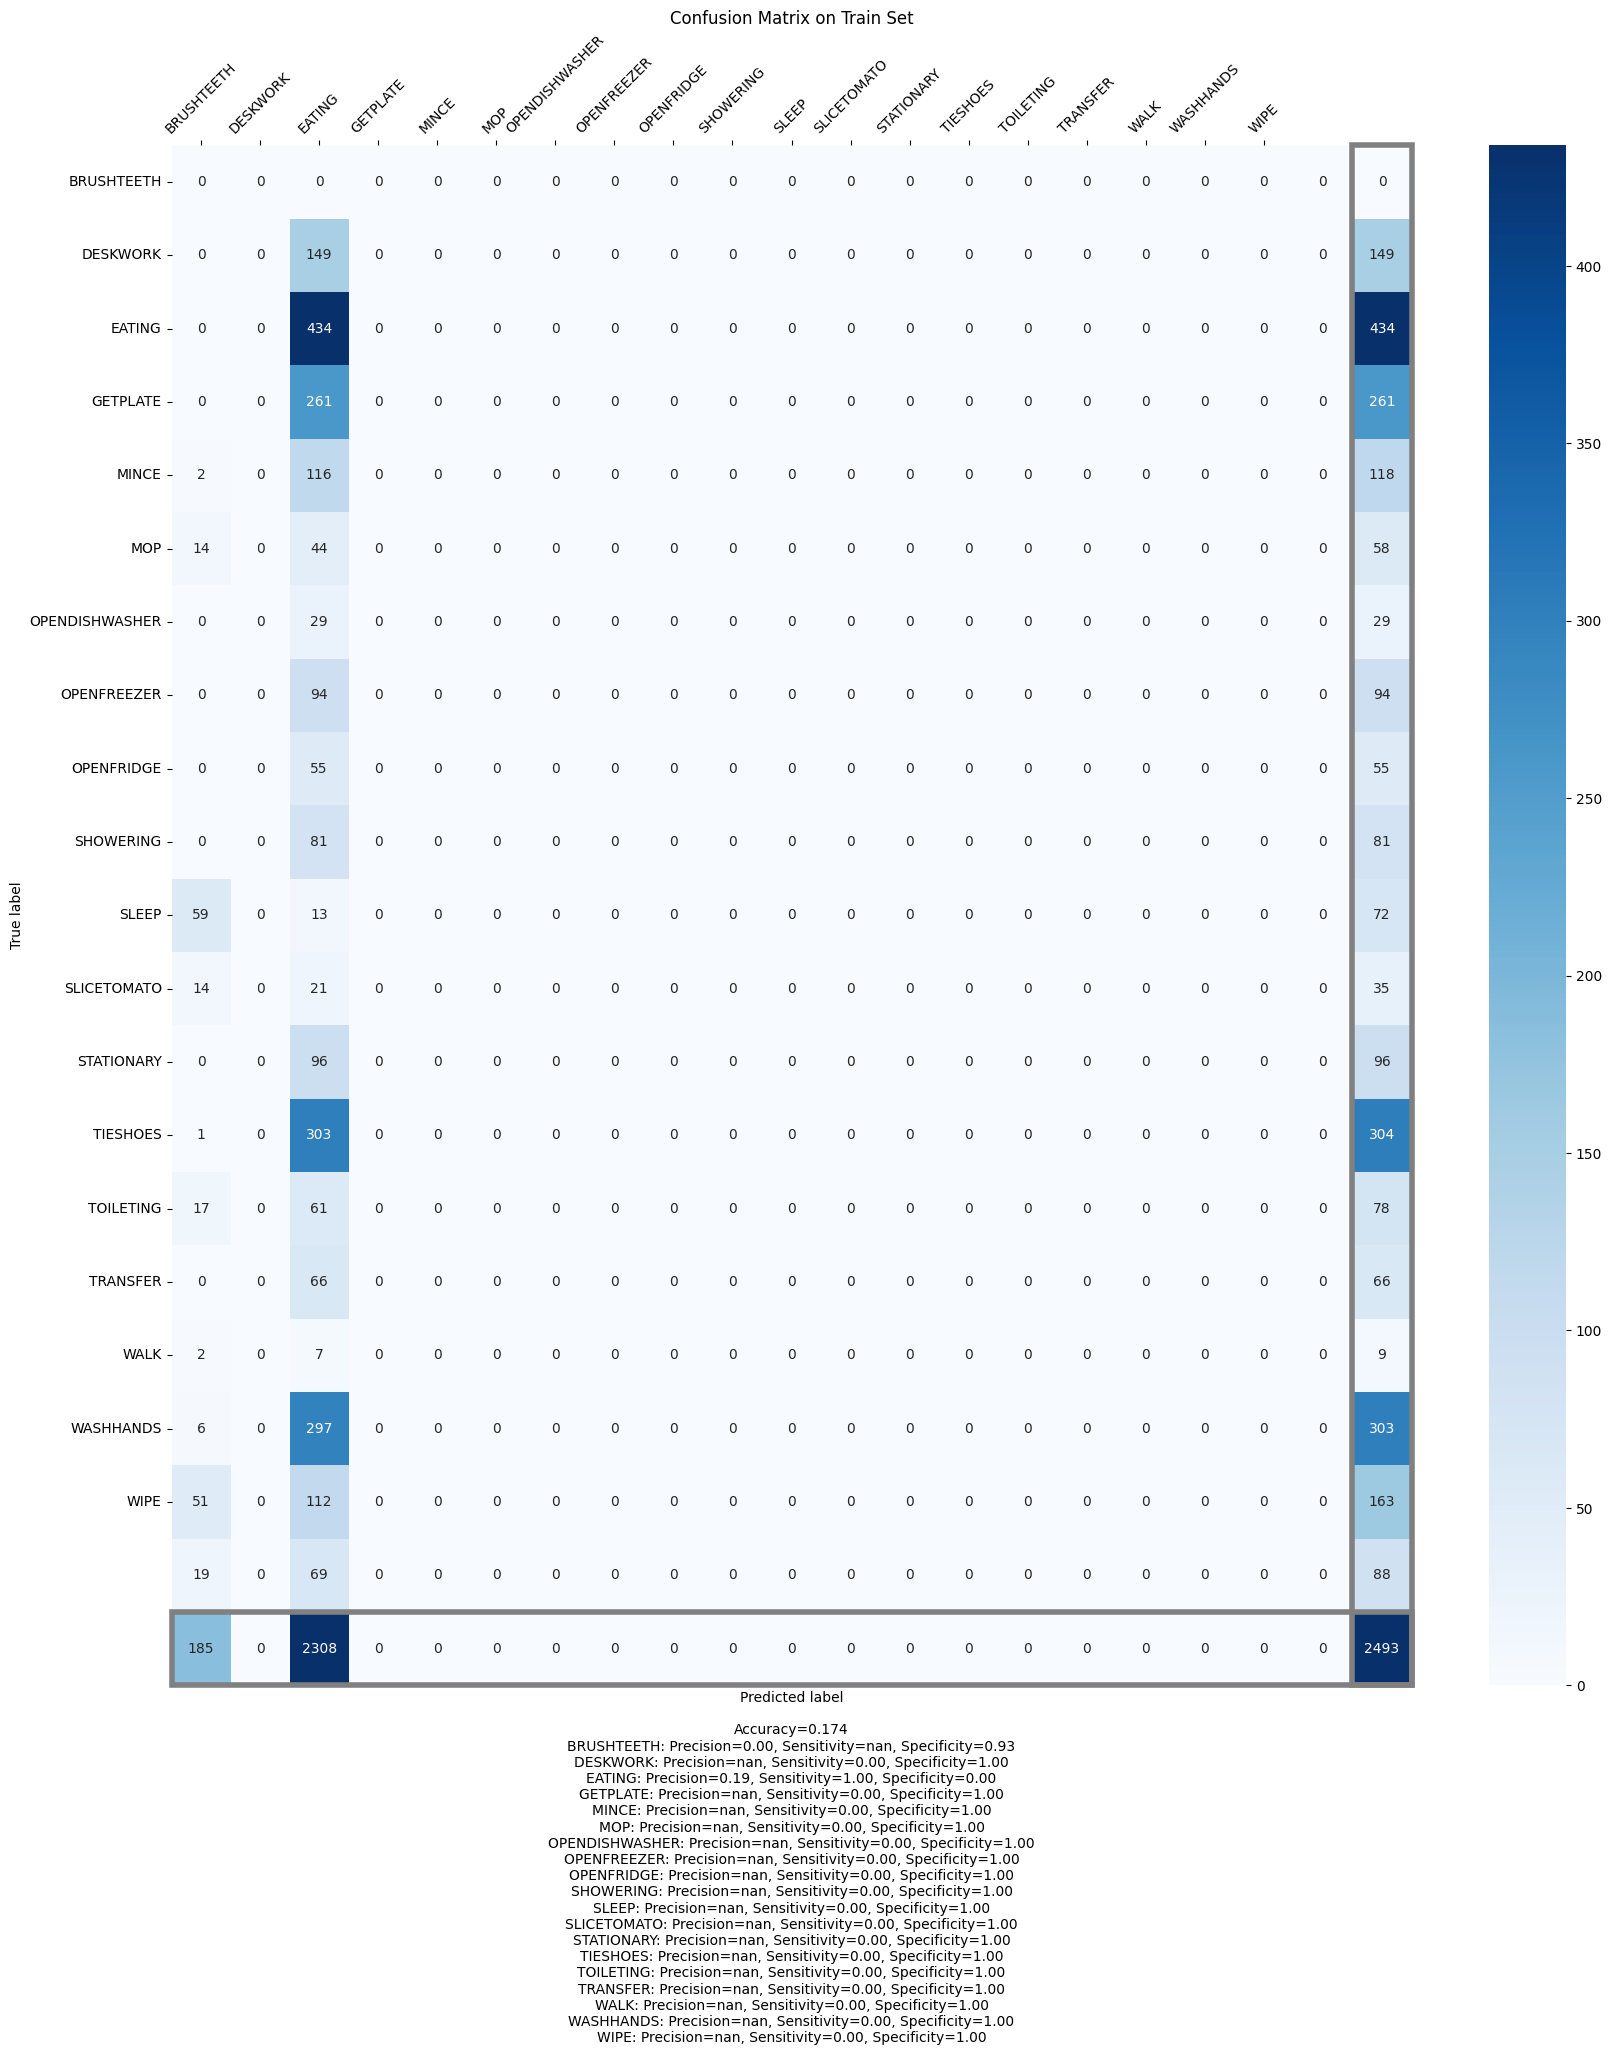

In [3]:
# MARK: - VISUALIZATION

categories = label_encoder.classes_
print(categories)
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred) 
#print(cf_matrix)
utils.make_confusion_matrix(cf_matrix, categories=categories, figsize=(20,20), percent=False, title="Confusion Matrix on Test Set")

y_pred = clf.predict(X_train)
cf_matrix = confusion_matrix(y_train, y_pred) 
utils.make_confusion_matrix(cf_matrix, categories=categories, figsize=(20,20), percent=False, title="Confusion Matrix on Train Set")


# # Plot the tree *** Only for the tree classifier
# plt.figure(figsize=(100,100))
# tree.plot_tree(clf, class_names=categories, feature_names=cleaned_data.drop('ACTIVITY', axis=1).columns)


In [4]:
# Cross Validation
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score, accuracy_score

# k = 5
# kf = StratifiedKFold(n_splits=k, random_state=0, shuffle=True)
# cross_clf = svm.SVC(kernel='linear', C=10)

# accuracy = []

# for train_ind, test_ind in kf.split(X, y):
#     X_train, X_test = X[train_ind], X[test_ind]
#     y_train, y_test = y[train_ind], y[test_ind]

#     print("Shape X_train: ", X_train.shape, " Shape X_test: ", X_test.shape)
#     cross_clf.fit(X_train, y_train)
#     y_pred = cross_clf.predict(X_test)

#     accuracy.append(accuracy_score(y_pred, y_test))

# print(accuracy)

